# Introduction to finite differences: stationary 1D problems

In [1]:
# some preliminary operations: let's import useful modules
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
%matplotlib notebook

---

## A) Steady 1D diffusion

Consider the following boundary value problem defined on the domain $x \in [0, L]$:

$$
\begin{cases}
    0 = \kappa \dfrac{\partial^2 T}{\partial x^2} + s(x) \\
    T(0) = T_R \\
    \dfrac{dT}{dx}(L) = \theta
\end{cases}
$$

such problem could describe the diffusion of heat on a cantilever beam, and consists in [Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation) completed with Dirichlet boundary conditions at $x=0$ and Neumann boundary conditions at $x=L$. Function $s(x)$ represents a temperature source term, whereas temperature $T(x)$ is the unknown of the problem; finally, $\kappa$ is a constant indicating thermal diffusivity (which is not to be confused with thermal conductivity).

<img src="https://git.scc.kit.edu/ar8439/pic-repo/-/raw/master/numerics/poisson_eq/problem_descr.png" alt="Drawing" style="height: 200px;"/>

### 1. Discretisation of domain and unknown

We now want to discretise and solve this equation. First off, the domain is discretised in a set of `N` equally spaced points $x_i$; let $\Delta x$ be the constant spacing between nodes (a node is each of the points $x_i$).

<img src="https://git.scc.kit.edu/ar8439/pic-repo/-/raw/master/numerics/poisson_eq/mesh.png" alt="Drawing" style="height: 200px;"/>

The value of temperature at each node is indicated with $T_i$, meaning that the unknown of the discretised problem will be the set of all $T_i$s. The temperature source term (which is known, albeit not yet specified) can be easily evaluated at each $x_i$ as well; it will be indicated as $s_i$.

### 2. Discretisation of equation

After the domain and the unknown, it is now the equation's turn to be discretised. Let's start by evaluating it at a generic point $x_i$:

$$  0 = \kappa \frac{\partial^2 T}{\partial x^2}(x_i) + s_i  $$

The only remaining step is to express the second order derivative of $T$ at $x_i$ in terms of the discretised values of $T_i$; this is done by __finite differencing__. Since we have a second order derivative, the choice of differencing scheme is straightforward: a _second order central_ one is used.

$$ \frac{\partial^2 T}{\partial x^2}(x_i) \approx \frac{T_{i+1} - 2T_{i} + T_{i-1}}{(\Delta x)^2} $$

The scheme is called _central_ since it uses values from the surrounding nodes ($i+1$ and $i-1$) to evaluate the derivative in $x_i$;

<img src="https://git.scc.kit.edu/ar8439/pic-repo/-/raw/master/numerics/finite_diff/centered_stencil.svg" alt="Drawing" style="height: 70px;"/>

it is a _second order_ scheme since:

$$ \frac{T_{i+1} - 2T_{i} + T_{i-1}}{(\Delta x)^2} - T''(x_i) = O((\Delta x)^2) \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\text{for } \,\Delta x \to 0$$

The full discretised equation at point $x_i$ can thus be written as:

$$
\begin{bmatrix}0 & 0 & ... & -1 & 2 & -1 & ... & 0\end{bmatrix}\cdot
\begin{pmatrix}
T_1 \\
T_2 \\
... \\
T_{i-1} \\
T_{i} \\
T_{i+1} \\
... \\
T_{N}
\end{pmatrix} = \frac{(\Delta x)^2}{\kappa}s_i
$$

where the row vector on the left hand side is formed by all zeroes except for the $i-1$th, $i$th and $i+1$th elements, which are $-1$, $2$ and $-1$ respectively.

### 3. Formation of a linear system

The above equation can only be written for nodes from $i=1$ to $i=N-1$; this because the second order central finite difference is not defined on nodes $1$ and $N$, as it would require data from nodes $0$ or $N+1$ - which do not exist. Hence, $N-2$ equations can be written in total; in order to have an even number of unknowns and equations, one needs to add boundary conditions. The Dirichlet one easily reads:

$$ T_1 = T_R $$

where $T_R$ is known, while the Neumann one is discretised with a backwards first order finite difference:

$$  \frac{dT}{dx}(L) \approx \frac{T_N - T_{N-1}}{\Delta x} = \theta $$

Now we have $N$ equations and $N$ unknowns; thus, a solveable linear system can be formed so that:
- the first row represents the Dirichlet boundary condition at $x=0$;
- the last row represents the Neumann boundary condition at $x=L$;
- all the remaining rows represent the discretised Poisson equation at each node $i$, with $i=2,...,N-1$.

This basically results in:

$$
\underbrace{
    \begin{bmatrix}
        1 & & & & & &  \\
        -1 & 2 & -1 & & & &  \\
        & -1 & 2 & -1 & & &  \\
        & & -1 & 2 & -1 & & &  \\
        & & & \ddots & \ddots & \ddots &  \\
        & & & & -1 & 2 & -1 \\
        & & & & &-1 & 1
    \end{bmatrix}
}_{\Large{\textbf{A}}}
\cdot
\underbrace{\begin{pmatrix} T_1 \\ T_2 \\ T_3 \\ T_4 \\ \vdots \\ T_{N-1} \\ T_{N} \end{pmatrix}}_{\Large{\vec{T}}}
=
\underbrace{
    \begin{pmatrix}
        T_{R} \\
        (\Delta x)^2 s_1 / \kappa \\
        (\Delta x)^2 s_2 / \kappa\\
        (\Delta x)^2 s_3 / \kappa\\
        \vdots \\
        (\Delta x)^2 s_{N-1} / \kappa\\
        \theta \cdot \Delta x
    \end{pmatrix}
}_{\Large{\vec{b}}} \\
\Large{\textbf{A} \, \vec{T} = \vec{b}}
$$

### 4. Choosing how to store data in memory

We have now cast a continuous boundary value problem to an algebraic one (a linear system) thanks to discretisation; in order to practically solve it, it has to be decided how to store data in memory. The choice is straightforward: the unknown $\vec{T}$ will be represented by a 1D array (which basically is a vector), where each cell corresponds to a given $x_i$ - just as in the system above.

However, we will see that such choice is not nearly as easy for a 2D problem.

### 5. Writing code

Now, everything is set; it is thus time to write the actual solver. Let's start by defining some constants; as for the source term $s_i$, it will be 0 everywhere except for two points - the ones with indices $2$ and $4$. There $s_i$ will have a constant value `s`.

In [2]:
#################
# USER SETTINGS #
#################

N = 20 # [-] number of nodes
L = 10 # [m] domain length
dx = L/(N-1) # [m] grid resolution

kappa = 10 # [m^2/s] thermal diffusivity
s = 0 # [K/s] temperature source
theta = 50 # [K/m] temperature gradient at the end of the beam
tr = 50 # [K] temperature at the root of the beam

This allows us to define a mesh; still notice that it won't be necessary for the solution of the problem, it will only be used later on for plotting.

In [3]:
x = np.linspace(0, L, num=N)

Next on, let's define a function calculating matrix $\textbf{A}$ and known-term vector $\vec{b}$:

In [4]:
# allocation (A is built as a tridiagonal matrix associated to the discretised Poisson equation)
A = np.diag(-np.ones(N-1),-1) + np.diag(-np.ones(N-1),1) + np.diag(2*np.ones(N))
b = np.zeros(N)

# Dirichlet condition
A[0,0] = 1; A[0,1] = 0
b[0] = tr

# Neumann condition (notice that A[-1, -2] already has correct value)
A[-1,-1] = 1
b[-1] = theta * dx

# heat sources
b[2] = dx**2 * s / kappa
b[4] = dx**2 * s / kappa

# print stuff to screen to check that everything is correct
print('A:'); print(A); print()
print('b:'); print(np.around(b,1))

A:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0. 

Now the linear system is solved with numpy's own function in order to find $\vec{T}$:

In [5]:
t = np.linalg.solve(A, b)

### 6. Plotting solution; comparison with analytic solution

<IPython.core.display.Javascript object>


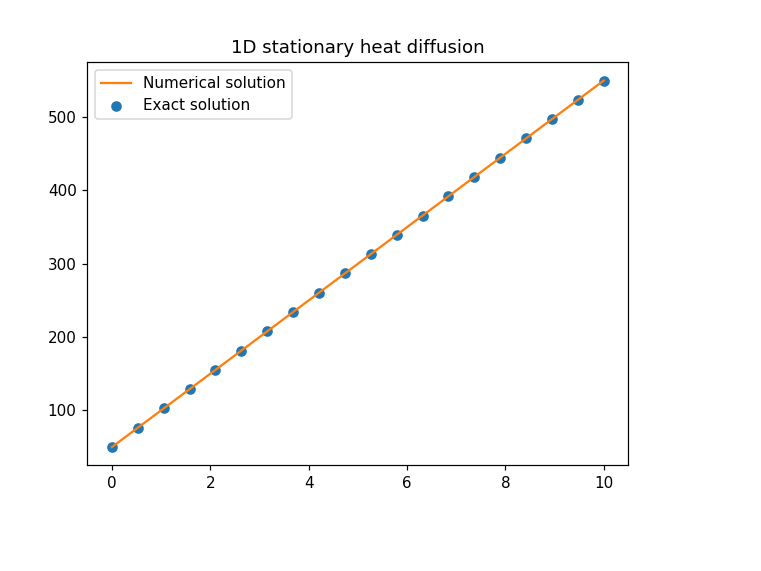

In [6]:
fig, ax = plt.subplots()
ax.set_title('1D stationary heat diffusion')
ax.plot(x, t, color='#ff7f0e')
ax.legend(['Numerical solution'])

The following function computes the analytical solution:

In [7]:
def get_analytical_sol(N,dx,kappa,s,tr,theta):
    exact = np.zeros(N)
    exact[0] = tr
    m = theta + 2*s/kappa*dx
    for ii in range(1,len(exact)):
        exact[ii] = exact[ii-1] + dx*m
        if ii == 4 or ii == 2:
            m = m - s/kappa*dx
    return exact

The analytical solution is then added to the previous plot:

In [8]:
exact = get_analytical_sol(N,dx,kappa,s,tr,theta)
ax.scatter(x, exact)
ax.legend(['Numerical solution', 'Exact solution'])

The local error is then calculated and plotted:

<IPython.core.display.Javascript object>


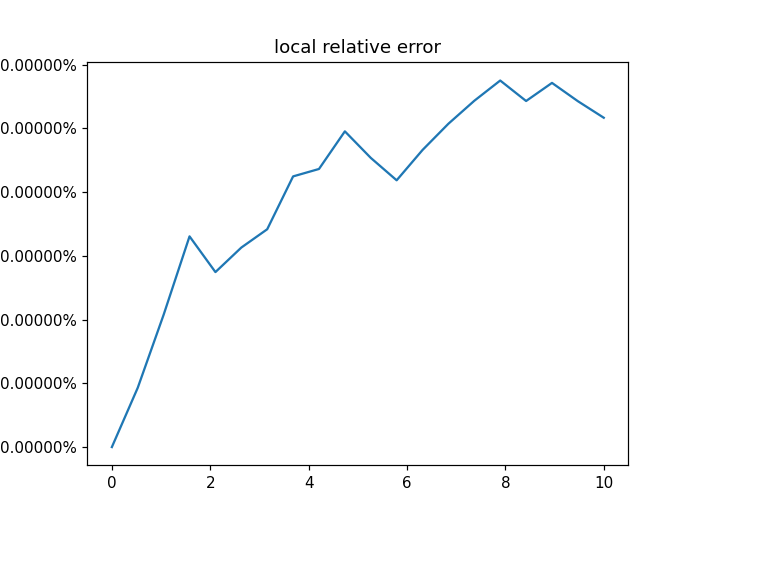

Average relative error =  8.055886878062834e-14 %


In [9]:
lerr = abs((exact - t)/exact)*100
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('local relative error')
ax.plot(x, lerr)

print('Average relative error = ', lerr.mean(), '%')

---

## B) Steady 1D convective and diffusive transport 

Let's now slightly change the governing equation of our problem: the forcing (source) term is removed, and a convective transport one is added:

$$ U \frac{\partial T}{\partial x} =\kappa \frac{\partial^2 T}{\partial x^2} $$

where $U$ is a known constant, representing convection velocity. Such problem is governed by the Peclet number:

$$ Pe = \frac{U\ell}{\kappa} $$

$\ell$ being a characteristic length. Here, the domain length $L$ (which is, the length of the beam) is used as the characteristic length: $\ell = L$. One can also define a local Peclet number using the mesh resolution $\Delta x$ as the characteristic length; such local Peclet number will be of crucial importance for the stability of some schemes, as we are about to see.

$$ Pe_{local} = \frac{U \Delta x}{\kappa} $$

The problem is completed by Dirichlet boundary conditions applied at both ends of the domain:

$$ T(0) = 0 $$
$$ T(L) = T_L $$


### 1. Discretisation

Discretisation is performed in the same way as the previous example; however, it is now necessary to discretise the convective term. To do so, one has two alternatives - namely, using a centered scheme or an upwind one. The centered one reads:

$$ \left( U \frac{\partial T}{\partial x} \right)_i \approx U \frac{T_{i+1}-T_{i-1}}{2\Delta x} $$

which can be rewritten using purposely defined coefficients:

$$ \left( U \frac{\partial T}{\partial x} \right)_i \approx  A_E^c T_{i+1} + A_P^c T_i + A_W^c T_{i-1} $$
$$ A_E^c = \frac{U}{2 \Delta x}; \; A_W^c = -\frac{U}{2 \Delta x}; \; A_P^c = - (A_E^c + A_W^c)=0 $$

The alternative is represented by the upwind scheme; this is a forward or backward finite difference that gathers data from the direction of the convective velocity, meaning that:

$$ \left( U \frac{\partial T}{\partial x} \right)_i \approx U \frac{T_i - T_{i-1}}{x_i - x_{i-1}}\ \text{, if} \ U > 0 \\
\left( U \frac{\partial T}{\partial x} \right)_i \approx U \frac{T_{i+1} - T_{i}}{x_{i+1} - x_{i}}\ \text{, if} \ U < 0 $$

which can be rewritten in the same form as centered differences, albeit with different coefficients:

$$  A_E^u = \frac{min(U,0)}{\Delta x}; \; A_W^u = -\frac{max(U,0)}{\Delta x}; \; A_P^u = - (A_E^u + A_W^u) $$

Notice how the stencil changes in case of an upwind scheme; now, information from only 2 grid points is used (meaning that the scheme will be first order).

<img src="https://git.scc.kit.edu/ar8439/pic-repo/-/raw/master/numerics/finite_diff/upwind_stencil.svg" alt="Drawing" style="height: 140px;"/>

Both alternatives are here implemented; the user selects the desired one with a flag.

### 2. Writing the linear system

Discretisation of this system leads again to a system of the type $\textbf{A} \vec{T} = \vec{b}$; in this case, though, $\vec{b}$ is composed of all zeroes (except for the elements corresponding to boundary conditions). On the other hand, $\textbf{A}$ is given by the sum of a convective and a diffusive contribution:

$$ \textbf{A} = \textbf{A}_{conv} + \textbf{A}_{diff} $$

Similarly to the previous case, $\textbf{A}_{diff}$ can be written as (watch out for the coefficient, which in the previous case was shifted to $\vec{b}$):

$$\textbf{A}_{diff} = \frac{\kappa}{(\Delta x)^2} \begin{bmatrix}
        ... & & & & & &  \\
        -1 & 2 & -1 & & & &  \\
        & -1 & 2 & -1 & & &  \\
        & & -1 & 2 & -1 & & &  \\
        & & & \ddots & \ddots & \ddots &  \\
        & & & & -1 & 2 & -1 \\
        & & & & & & ...
    \end{bmatrix} $$
    
whereas the convective term reads:

$$\textbf{A}_{conv} = \begin{bmatrix}
        ... & & & & & &  \\
        A_W & A_P & A_E & & & &  \\
        & A_W & A_P & A_E & & &  \\
        & & A_W & A_P & A_E & & &  \\
        & & & \ddots & \ddots & \ddots &  \\
        & & & & A_W & A_P & A_E \\
        & & & & & & ...
    \end{bmatrix} $$
    
This allows to fully specify the linear system, which can thus be solved.

### 3. Writing code

Variables will be stored in memory just like in the previous example; therefore we can get cracking with some code.

In [10]:
#################
# USER SETTINGS #
#################

N = 11 # [-] number of nodes
L = 10 # [m] domain length
dx = L/(N-1) # [m] grid resolution

# selection of differencing scheme for convective term
conv_scheme = 'centered' # alternatives: 'centered' or 'upwind'

peclet = 2 # [-] Peclet number
kappa = 10 # [m^2/s] thermal diffusivity
tright = 10 # [K] temperature at the end of the beam
tleft = 0 # [K] temperature at the root of the beam

U = peclet*kappa/L # [m/s] convection velocity
print('Local Peclet number: ', dx*U/kappa) # local Peclet number

Local Peclet number:  0.2


In [11]:
x = np.linspace(0, L, num=N)

In [12]:
# allocation of A: DIFFUSIVE TERM
A = kappa/(dx**2)*(np.diag(-np.ones(N-1),-1) + np.diag(-np.ones(N-1),1) + np.diag(2*np.ones(N)))

# calculate coefficients depending on choice of scheme
if conv_scheme == 'centered':
    AN = U / (2*dx)
    AP = - U / (2*dx)
elif conv_scheme == 'upwind':
    AN = min(U,0) / dx
    AP = -max(U,0) / dx
else:
    raise Exception('an invalid scheme was selected; please set conv_scheme to either "centered" or "upwind".')
AC = -(AN+AP)

# calculation of CONVECTIVE TERM of A
A = A + AP*np.diag(np.ones(N-1),-1) + AN*np.diag(np.ones(N-1),1) + AC*np.diag(np.ones(N))

# allocation of b
b = np.zeros(N)

# Dirichlet condition
A[0,0] = 1; A[0,1] = 0
b[0] = tleft
A[-1,-1] = 1; A[-1, -2] = 0
b[-1] = tright

# print stuff to screen to check that everything is correct
print('A:'); print(A); print()
print('b:'); print(np.around(b,1))

A:
[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-11.  20.  -9.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -11.  20.  -9.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -11.  20.  -9.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -11.  20.  -9.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -11.  20.  -9.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -11.  20.  -9.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -11.  20.  -9.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -11.  20.  -9.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -11.  20.  -9.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]]

b:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]


Finally, the linear system is solved:

In [13]:
t = np.linalg.solve(A, b)

### 4. Plotting solution; comparison with analytic solution

<IPython.core.display.Javascript object>


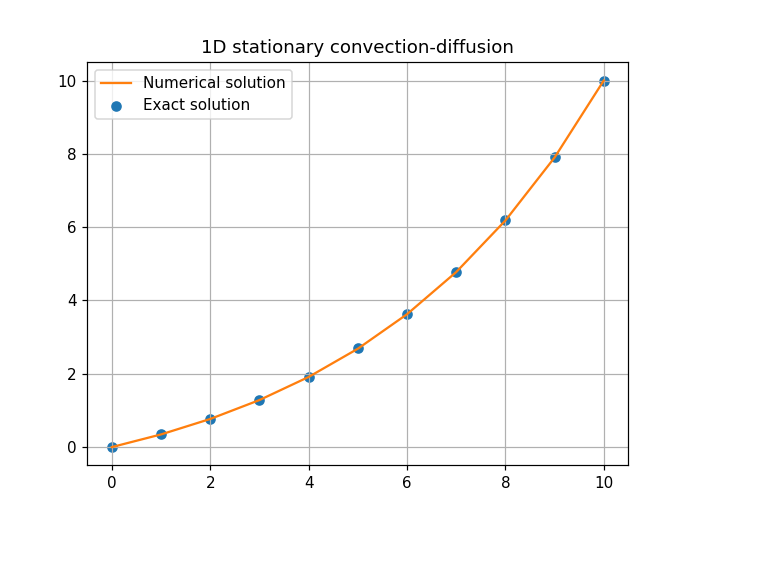

In [14]:
fig, ax = plt.subplots()
ax.set_title('1D stationary convection-diffusion')
ax.plot(x, t, color='#ff7f0e')
ax.legend(['Numerical solution'])
ax.grid()

The exact solution is then calculated:

In [15]:
exact_sol = b[0] + (np.exp(peclet*x/L)-1)/(np.exp(peclet)-1) * (b[-1] - b[1])

and it is then added to the previous plot:

In [16]:
ax.scatter(x, exact_sol)
ax.legend(['Numerical solution', 'Exact solution'])

The local error is then calculated and plotted:

<IPython.core.display.Javascript object>


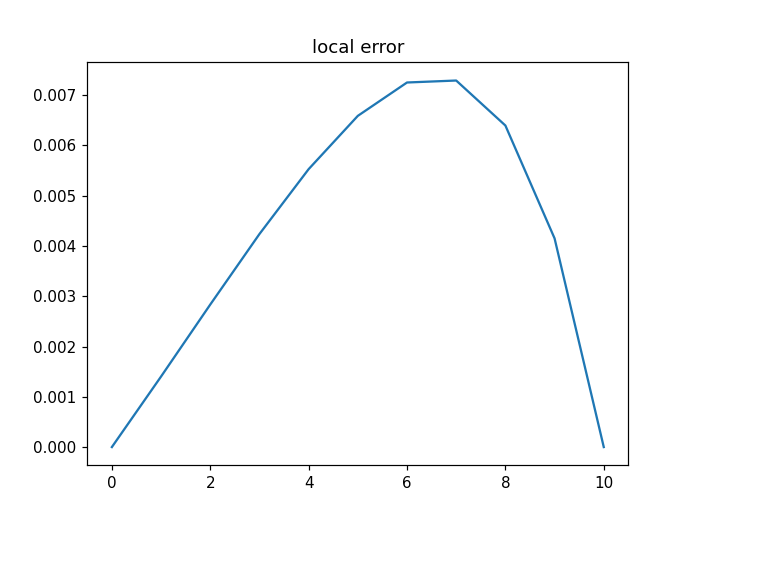

Average local error =  0.004152921021484537


In [17]:
lerr = abs((exact_sol - t))
fig, ax = plt.subplots()
ax.set_title('local error')
ax.plot(x, lerr)

print('Average local error = ', lerr.mean())

__Try and input different values for the Peclet number. Is the centered scheme always stable? How is stability related to the local Peclet number?__ In particular:
- using a centered scheme, change the Peclet number and assess stability;
    - try some Peclet number which translates to a __local__ Peclet number below 2;
    - try some other Peclet number which corresponds to a __local__ one greater than 2.
- by using the same Peclet number as before, switch to an upwind scheme. What happens?